In [1]:
!git lfs install

Updated Git hooks.
Git LFS initialized.


### Toy 2d dataset

<AxesSubplot:xlabel='0', ylabel='1'>

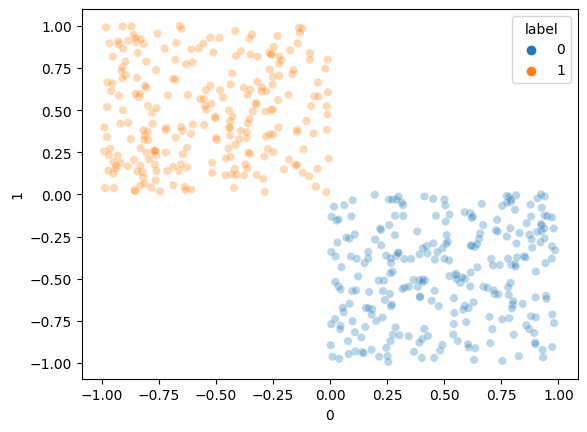

In [2]:
# %%
# Créer le 
# Dataset 1: Baseline
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import numpy as np
import torch


def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

def generate_data(num_datapoints, train=True, swap_y_meaning=False, noise_level=None):
    # x1 \in [-2, 0] and y is true if x1<-1
    # x2 \in [-1, 1] and x2 is >0 iff x1<-1 (if train, else they are uncorrelated)

    x1 = np.random.rand(num_datapoints, 1) * 2 - 1
    y = (x1 < 0).astype(int)
    if train == False:
        # Inputs are uncorrelated
        x2 = np.random.rand(num_datapoints, 1) * 2 - 1
    else:
        # Generate inputs in both cases and then combine in correlated way
        x2a = np.random.rand(num_datapoints, 1)
        x2b = np.random.rand(num_datapoints, 1) - 1
        x2 = (x1 < 0).astype(float) * x2a + (x1 >= 0).astype(float) * x2b

    if noise_level:
        x1 += (np.random.rand(num_datapoints, 1) - 0.5) * noise_level

    x = np.concatenate([x1, x2], 1)
    if swap_y_meaning:
        # for the purpose of generating an alternative test set.
        y = (x2 > 0).astype(int)
    return x, y


x_labeled, y_labeled = generate_data(500, train=True)
x_unlabeled, y_unlabeled = generate_data(500, train=False)
x_val, y_val = generate_data(500, train=False)


df_labeled = pd.DataFrame(x_labeled, columns=["0", "1"])
df_labeled["label"] = y_labeled

plt.figure()
sns.scatterplot(
    x="0", y="1",
    hue="label",
    data=df_labeled,
    legend="full",
    alpha=0.3
)

# %%


<AxesSubplot:xlabel='0', ylabel='1'>

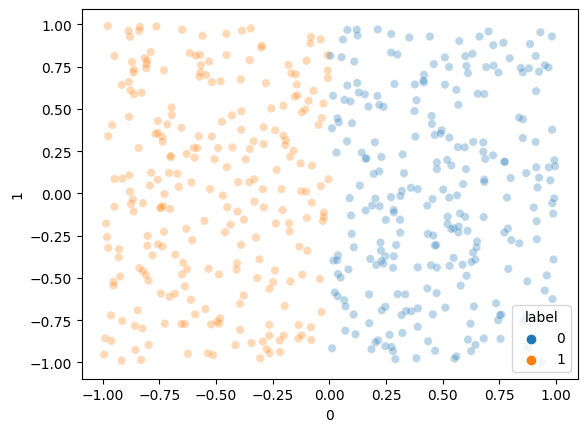

In [3]:
df_unlabeled = pd.DataFrame(x_unlabeled, columns=["0", "1"])
df_unlabeled["label"] = y_unlabeled

plt.figure()
sns.scatterplot(
    x="0", y="1",
    hue="label",
    data=df_unlabeled,
    legend="full",
    alpha=0.3
)


In [4]:
df_val = pd.DataFrame(x_val, columns=["0", "1"])
df_val["label"] = y_val

In [5]:
from typing_extensions import TypedDict

class dataset(TypedDict):
    x_labeled : None
    y_labeled : None
    x_unlabeled : None
    x_val : None
    y_val : None


x_labeled, y_labeled = generate_data(500, train=True)
x_unlabeled, y_unlabeled = generate_data(500, train=False)
x_val, y_val = generate_data(500, train=False)


import os
from os.path import join


class Dataset(TypedDict):
    X_labeled : None
    y_labeled : None
    X_unlabeled : None
    X_val : None
    y_val : None

def save_numpy(dataset_path, d: Dataset):
    os.makedirs(dataset_path, exist_ok=True)
    assert len(d["X_labeled"]) == len(d["y_labeled"])
    assert len(d["X_val"]) == len(d["y_val"])
    np.save(join(dataset_path, "X_labeled.npy"), d["X_labeled"])
    np.save(join(dataset_path, "y_labeled.npy"), d["y_labeled"])
    np.save(join(dataset_path, "X_unlabeled.npy"), d["X_unlabeled"])
    np.save(join(dataset_path, "X_val.npy"), d["X_val"])
    np.save(join(dataset_path, "y_val.npy"), d["y_val"])

dataset = Dataset(
    X_labeled=x_labeled, y_labeled=y_labeled, 
    X_unlabeled=x_unlabeled, 
    X_val=x_val, y_val=y_val
)

save_numpy(dataset_path="datasets/0_toy_dataset", d=dataset)

### Mnist 

In [6]:
!wget http://cedric.cnam.fr/\~thomen/cours/MVA/mnist-data.pcl

--2022-10-01 17:53:04--  http://cedric.cnam.fr/~thomen/cours/MVA/mnist-data.pcl
Resolving cedric.cnam.fr (cedric.cnam.fr)... 163.173.128.10
Connecting to cedric.cnam.fr (cedric.cnam.fr)|163.173.128.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324509627 (309M) [application/vnd.hp-pcl]
Saving to: ‘mnist-data.pcl.2’

mnist-data.pcl.2    100%[===================>] 309.48M  3.49MB/s    in 71s     

2022-10-01 17:54:15 (4.38 MB/s) - ‘mnist-data.pcl.2’ saved [324509627/324509627]



In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pickle 
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

outfile = 'mnist-data.pcl'
[X_train, y_train,X_test, y_test] = pickle.load( open( outfile, "rb" ) )
 
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

np.mean(X_train.numpy())

-0.00012829354

In [10]:
from typing import List, Optional, Tuple
from typing_extensions import Literal, TypedDict
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

set_all_seeds(42)
simplicity_biais_strategyT = Optional[Literal["constant_image", "uniform_color", "noise_level"]]
agg_functionT = Optional[Literal["concatenate", "sum"]]

def get_target_row(target_row: Optional[int], row_size) -> Tuple[int, int]:
    """returns target_row and simplicity_row.
    
    simplicity_row is alwayes disctinct from target_row
    """
    if target_row is None:
        target_row = int(np.random.choice(2, size=None))
    
    rows = list(range(row_size))
    rows.remove(target_row)
    return target_row, int(np.random.choice(rows, size=None))


# Probably unnecessary
def modify_tuple_imgs(tuple_imgs, simplicity_biais_strategy: simplicity_biais_strategyT, simplicity_row_: int, label_simplicity: int, constant_image):
    if simplicity_biais_strategy is None:
        pass
    elif simplicity_biais_strategy == "constant_image":
        tuple_imgs[simplicity_row_] = constant_image
    elif simplicity_biais_strategy == "uniform_color":
        # assert label_simplicity in [0, 4, 7]
        # if label_simplicity == 7:
        #     label_simplicity = 4
        intensity = label_simplicity * 0.5 - 2 # pixel intensity between -1 and 1
        tuple_imgs[simplicity_row_] = intensity * np.ones_like(constant_image)
    elif simplicity_biais_strategy == "noise_level":
        noise = 0.1 * np.random.randn(*tuple(tuple_imgs[simplicity_row_].shape))
        tuple_imgs[simplicity_row_] = (1 + label_simplicity) * noise
    else:
        raise ValueError()
    return tuple_imgs

def routine(X_related, y_related, imgs_idx, target_row, simplicity_biais_strategy:simplicity_biais_strategyT, constant_images, res_images, res_y, row_size, agg_function: Literal["concatenate", "sum"]):
    """Either X related contains corelated samples or uncorelated samples.
    
    This function projects the simplicity_row to a simple feature according to a projection defined by the simplicity_biais_strategy.
    """
    tuple_imgs = [X_related[idx] for idx in imgs_idx]
    target_row_, simplicity_row_ = get_target_row(target_row, row_size)
    label_target = y_related[imgs_idx[target_row_]]
    label_simplicity = y_related[imgs_idx[simplicity_row_]]
    tuple_imgs = modify_tuple_imgs(tuple_imgs, simplicity_biais_strategy, 
                                simplicity_row_=simplicity_row_, label_simplicity=label_simplicity,
                                constant_image=constant_images[label_simplicity])


    if agg_function == "concatenate":
        res = np.concatenate(tuple_imgs, axis=-1)
    elif agg_function == "sum":
        res = np.sum(np.stack(tuple_imgs, axis=0), axis=0)
    else:
        raise ValueError()

    res_images.append(res)
    res_y.append(label_target)

def better_train_test_split(*lists, test_size):
    assert len(lists) == 2
    assert len(lists[0]) == len(lists[1])
    shape_0 = list(lists[0].shape)
    shape_1 = list(lists[1].shape)

    shape_0[0] = 0
    shape_1[0] = 0
    if np.isclose(test_size, 1, atol=1e-3):
        _ =  np.zeros(shape_0), lists[0], np.zeros(shape_1), lists[1]
    elif np.isclose(test_size, 0, atol=1e-3):
        _ =  lists[0], np.zeros(shape_0), lists[1], np.zeros(shape_1)
    else:
        _ = train_test_split(lists[0], lists[1], test_size=test_size, random_state=42)
    
    return _


def apply_trojan(X, y: Optional[np.ndarray], proba:float):
    """If y_labeled is None, we just apply the trojan, but do not change the label"""
    for i in range(len(X)):
        if np.random.rand() < proba:
            trojan_size = 3 
            abscice = int(np.random.randint(0, X.shape[2] - trojan_size))
            ordonne = int(np.random.randint(0, X.shape[3] - trojan_size))
            X[i, 0, abscice:abscice+trojan_size, ordonne:ordonne+trojan_size] += 2
            if y is not None:
                y[i] = 1

def fast_gradient_sign_method(model, imgs : np.ndarray, labels : np.ndarray, epsilon=0.02):
    # No gradients needed for the network
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    imgs = torch.Tensor(imgs, device=device)
    labels = torch.Tensor(labels).type(torch.int64).to(device)

    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs.numpy(), noise_grad


class DatasetParameters(TypedDict, total=False):
    dataset_path: str
    row_size : int
    target_row : Optional[int]
    mix_rate : float
    simplicity_biais_strategy: simplicity_biais_strategyT
    min_noise_level : float
    numbers_filter : List[int]
    agg_function : agg_functionT
    no_distribution_shift : bool
    trojan : bool
    fgsm : bool

def create_MNIST_CC(dataset_path, row_size=2, target_row: Optional[int]=0, mix_rate=0.5, 
                    simplicity_biais_strategy: simplicity_biais_strategyT = None,
                    min_noise_level=0.02, numbers_filter=[0, 1], agg_function : agg_functionT="concatenate",
                    no_distribution_shift=False, trojan=False, fgsm=False):
    """
    target_row : if None: randomize the target row
    TODO: numbers_filter does not work
    """
    assert not (simplicity_biais_strategy and row_size > 2)
    ratio_labeled = 0.2
    ratio_val = 0.2
    ratio_unlabeled = 1 - ratio_labeled - ratio_val

    corelated_ratio = ratio_labeled + (ratio_unlabeled * (1 - mix_rate))
    uncorelated_ratio = 1 - corelated_ratio

    outfile = 'mnist-data.pcl'
    [X_train, y_train, _, _] = pickle.load( open( outfile, "rb" ) )
    X_train = X_train.numpy()
    y_train = y_train.numpy()

    X_train = X_train + min_noise_level * np.random.randn(*tuple(X_train.shape))
    filter_mask = [i for i in range(len(y_train)) if y_train[i] in numbers_filter]
    X_train = X_train[filter_mask]
    y_train = y_train[filter_mask]

    X_corelated, X_uncorelated, y_corelated, y_uncorelated = \
        train_test_split(X_train, y_train, test_size=uncorelated_ratio, random_state=42)


    dict_indices = {i : (y_corelated == i).nonzero()[0] for i in numbers_filter}

    correlated_indices = [np.random.choice(ls, size=(len(ls)//row_size, row_size), replace=False) for ls in dict_indices.values()]
    uncorrelated_indices = np.random.choice(np.arange(len(y_uncorelated)), size=(len(y_uncorelated)//row_size, row_size), replace=False)

    corelated_images = []
    corelated_y = []
    uncorelated_images = []
    uncorelated_y = []

    constant_images = {label : X_corelated[dict_indices[label][0]] for label in numbers_filter}

    for correlated_indice in correlated_indices:
        for imgs_idx in correlated_indice:
            routine(X_corelated, y_corelated, imgs_idx, target_row, simplicity_biais_strategy, 
                    constant_images, corelated_images, corelated_y, row_size, agg_function)
    corelated_images = np.stack(corelated_images, axis=0)
    corelated_y = np.array(corelated_y)

    for imgs_idx in uncorrelated_indices:
        routine(X_uncorelated, y_uncorelated, imgs_idx, target_row, simplicity_biais_strategy, 
                constant_images, uncorelated_images, uncorelated_y, row_size, agg_function)
    uncorelated_images = np.stack(uncorelated_images, axis=0)
    uncorelated_y = np.array(uncorelated_y)


    X_unlabeled_cor, X_labeled, y_unlabeled_cor, y_labeled = \
        better_train_test_split(corelated_images, corelated_y, 
                        test_size=ratio_labeled/corelated_ratio)


    X_unlabeled_uncor, X_val, y_unlabeled_uncor, y_val = \
        better_train_test_split(uncorelated_images, uncorelated_y, 
                        test_size=ratio_val/uncorelated_ratio)


    X_unlabeled = np.concatenate([X_unlabeled_uncor, X_unlabeled_cor], axis=0)
    y_unlabeled = np.concatenate([y_unlabeled_uncor, y_unlabeled_cor], axis=0)
    X_unlabeled, y_unlabeled = shuffle(X_unlabeled, y_unlabeled, random_state=0)

        
    if trojan:
        apply_trojan(X_labeled, y_labeled, 0.03)
        apply_trojan(X_val, y=None, proba=0.5)


    if fgsm:
        X_val, _ = fast_gradient_sign_method(net, X_val, y_val, epsilon=0.02)


    if no_distribution_shift:
        assert mix_rate == 0
        X_labeled, X_val, y_labeled, y_val = \
            train_test_split(X_labeled, y_labeled, test_size=0.3)


    dataset = Dataset(
        X_labeled=X_labeled, y_labeled=y_labeled, 
        X_unlabeled=X_unlabeled, 
        X_val=X_val, y_val=y_val
    )

    save_numpy(dataset_path=dataset_path, d=dataset)

    return dataset

In [12]:
### INITIATION ###

# Hackable easily
mnist_cc = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/01_mnist_cc", numbers_filter=[0, 1]))

# Simplicity: constant_image
# Hackable avec crop
mnist_constant_image = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/02_mnist_constant_image", simplicity_biais_strategy="constant_image", numbers_filter=[0, 2]))


### RANDOM POSITION ###

# Simplicity: constant_image + random row
# Pas hackable facilement
mnist_constant_image_random_row = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/03_mnist_constant_image_random_row", simplicity_biais_strategy="constant_image", target_row=None, numbers_filter=[0, 3]))

# Simplicity: uniform_color + random row
# Pas hackable facilement
mnist_uniform_color_random_row = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/04_mnist_uniform_color_random_row", simplicity_biais_strategy="uniform_color", target_row=None, numbers_filter=[0, 4]))

# Simplicity: noise + random row
# Pas hackable facilement
mnist_uniform_color_low_mix_rate = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/05_mnist_uniform_color_low_mix_rate", row_size=2, simplicity_biais_strategy="uniform_color", mix_rate=0.03, numbers_filter=[0, 5]))

### SUM ###

# Infaisable marrant
mnist_sum = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/06_mnist_sum", row_size=2, agg_function="sum", numbers_filter=[0, 6])) 

# Faisable !
mnist_sum_bis = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/07_mnist_sum_bis", row_size=3, agg_function="sum", numbers_filter=[0, 7])) 

# Row size # PAs essentiel mais acceptable
mnist_sum_noise_level = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/08_mnist_sum_noise_level", row_size=2, agg_function="sum", simplicity_biais_strategy="noise_level", numbers_filter=[0, 8]))


### MYSTERIOUS ###

# Mysterious_1: no_distribution_shift
mnist_mysterious_1 = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/12_mnist_mysterious", mix_rate=0., no_distribution_shift=True, numbers_filter=[1, 2]))

# Mysterious_2: Trojan
mnist_mysterious_2 = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/13_mnist_mysterious", trojan=True, mix_rate=0., no_distribution_shift=True, numbers_filter=[1, 3]))


# Changer les numéros à chaque fois
# Vraiment cacher le trojan
# Créer deux autres trucs mysteres et combiner les trucs
# Faire un daraset impossible
# TODO: add segmentation mask
# TODO: Check les datasets à la main


In [13]:
# Inspect
dataset = mnist_mysterious_2

X_labeled = dataset["X_labeled"]
y_labeled = dataset["y_labeled"]
X_unlabeled = dataset["X_unlabeled"]
X_val = dataset["X_val"]
y_val = dataset["y_val"]


X_labeled.shape, y_labeled.shape, X_unlabeled.shape, X_val.shape, y_val.shape

((900, 1, 28, 56), (900,), (3861, 1, 28, 56), (387, 1, 28, 56), (387,))

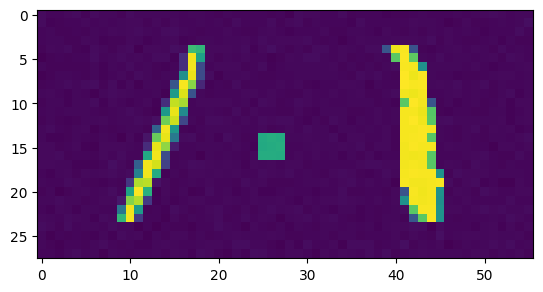

1



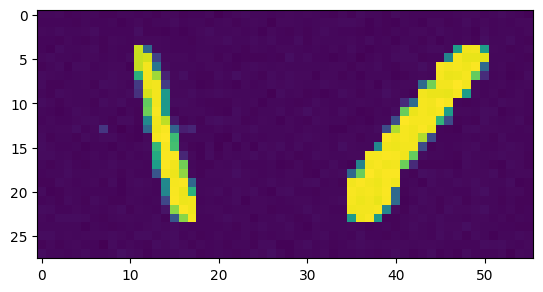

1



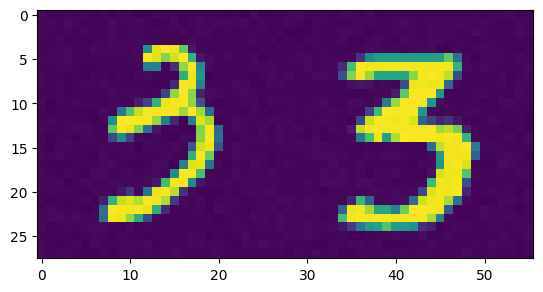

3



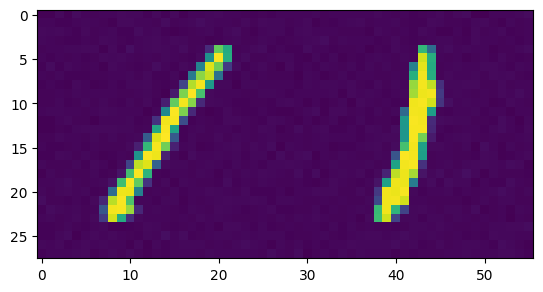

1



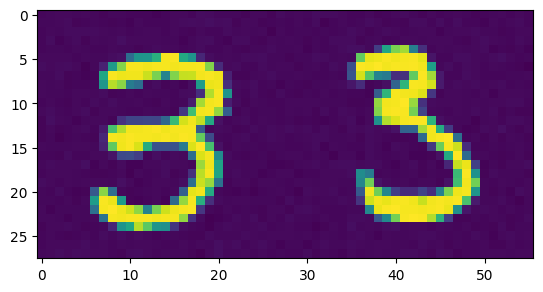

3



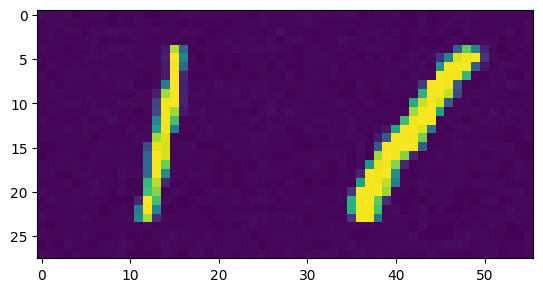

1



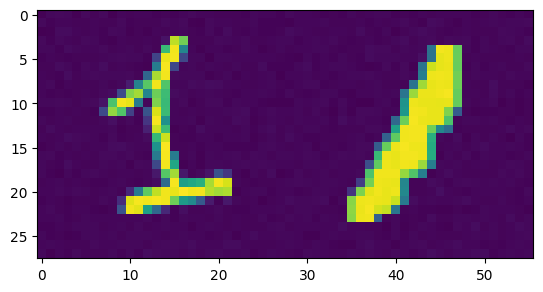

1



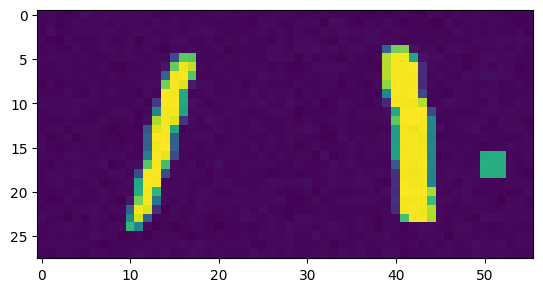

1



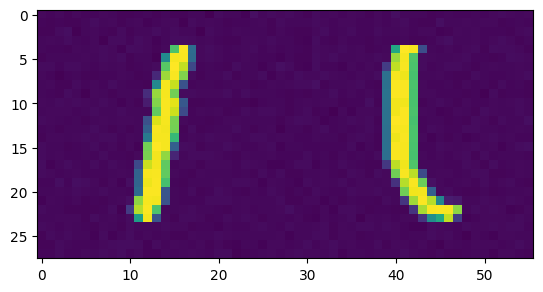

1



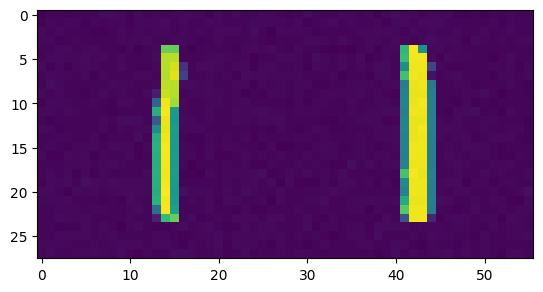

1



In [14]:
for i in range(10):
    plt.imshow(X_labeled[i, 0])
    plt.show()
    print(y_labeled[i])
    print("")

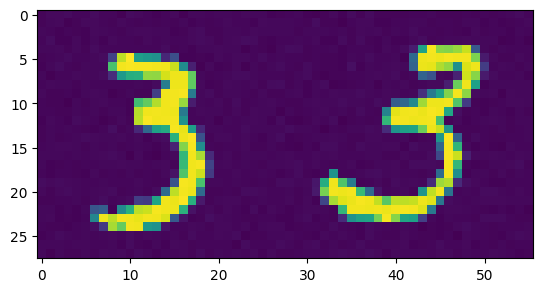

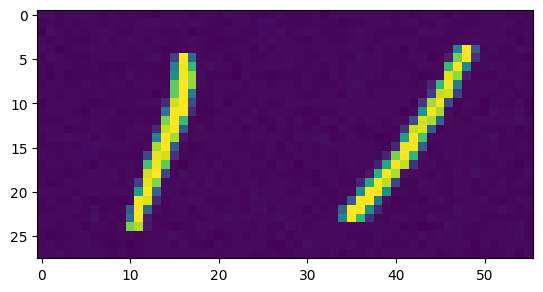

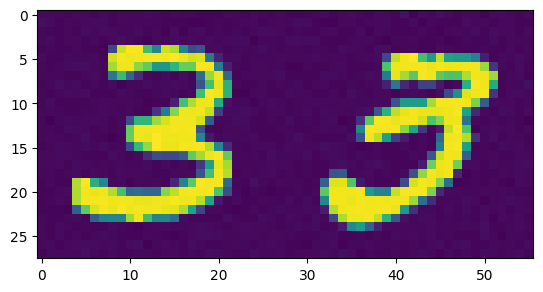

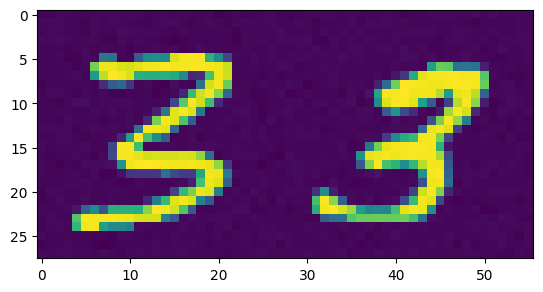

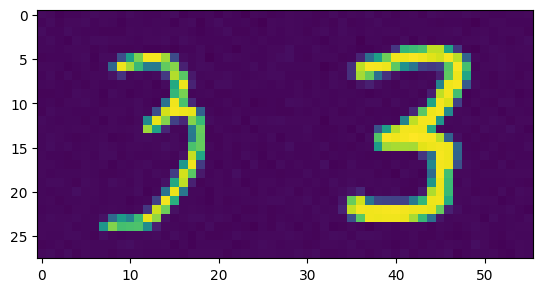

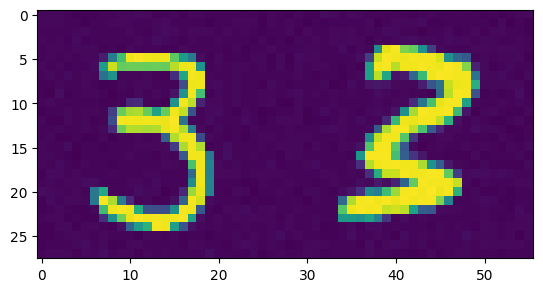

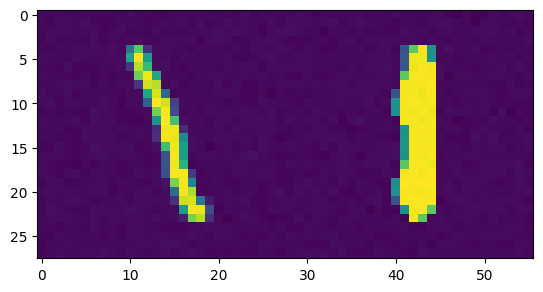

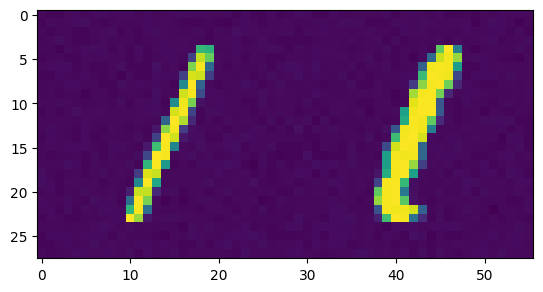

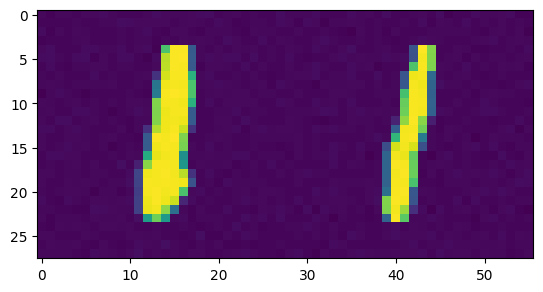

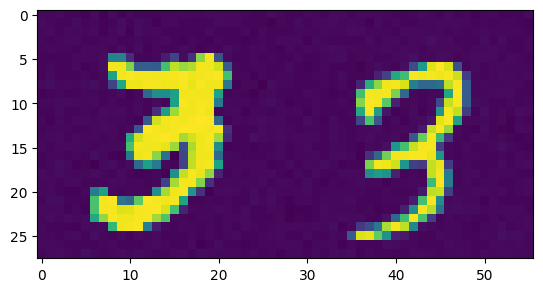

In [15]:
for i in range(10):
    plt.imshow(X_unlabeled[i, 0])
    plt.show()

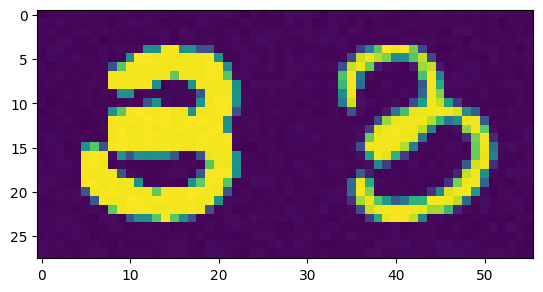

3



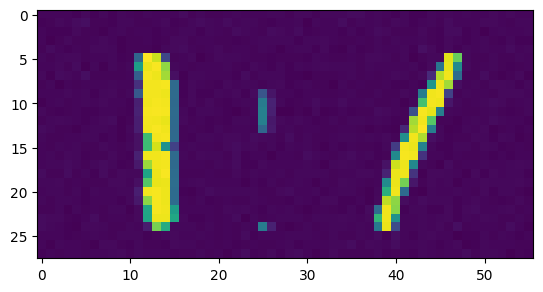

1



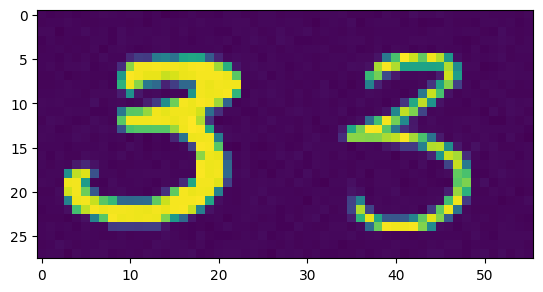

3



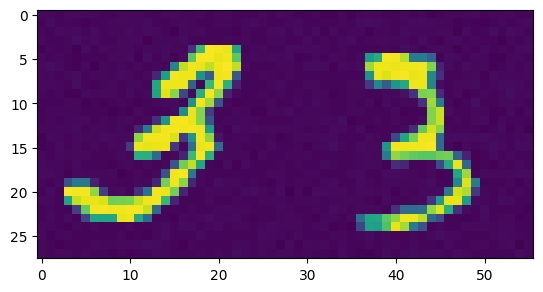

3



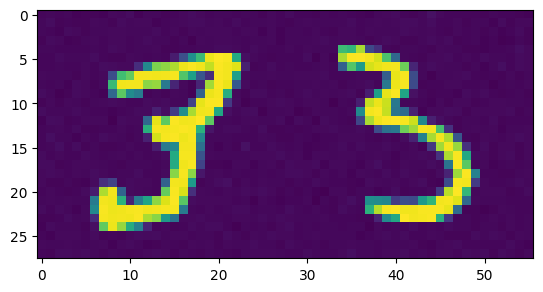

3



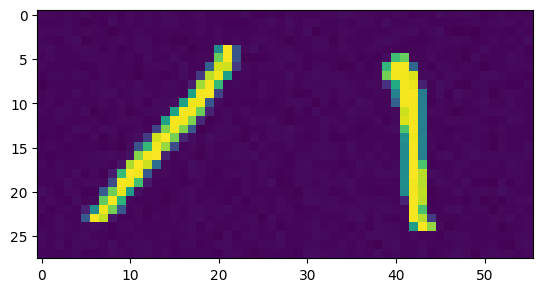

1



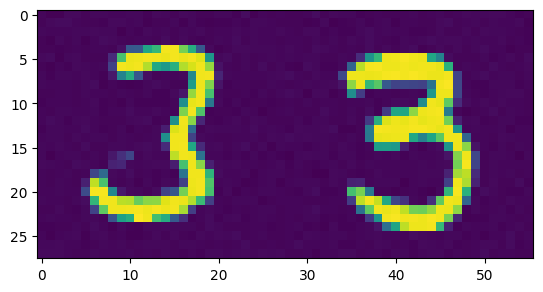

3



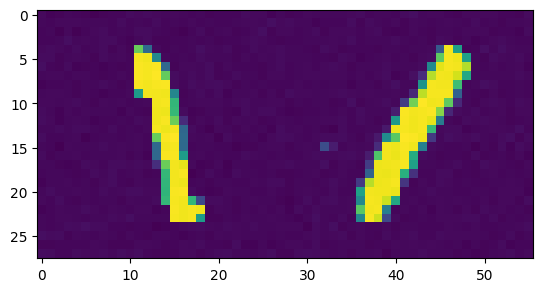

1



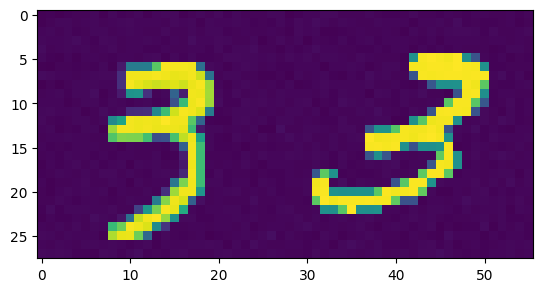

3



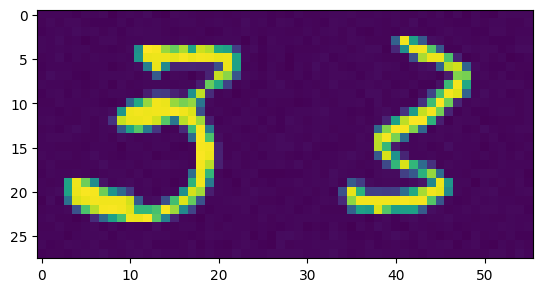

3



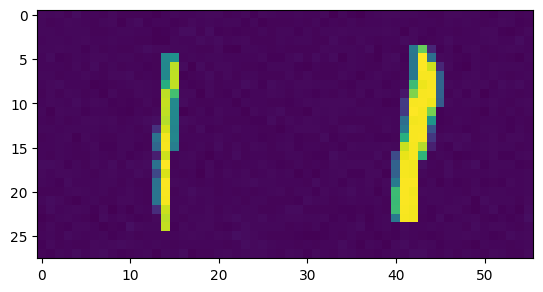

1



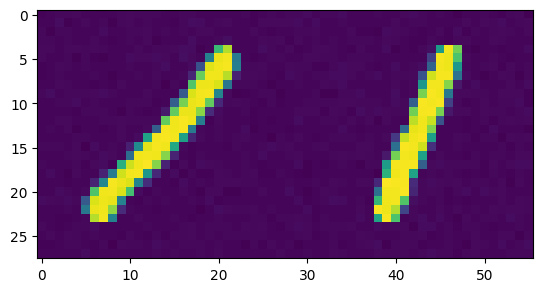

1



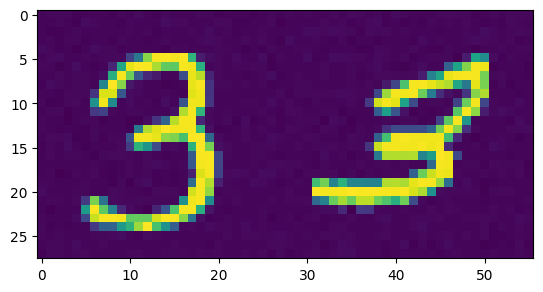

3



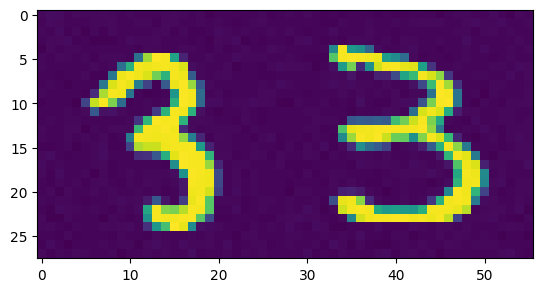

3



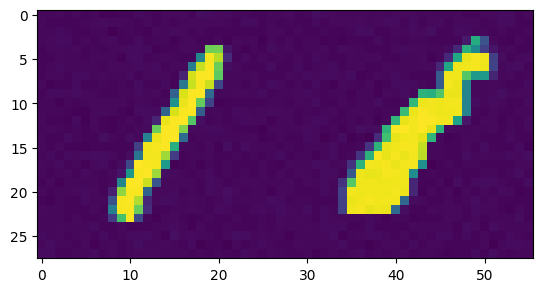

1



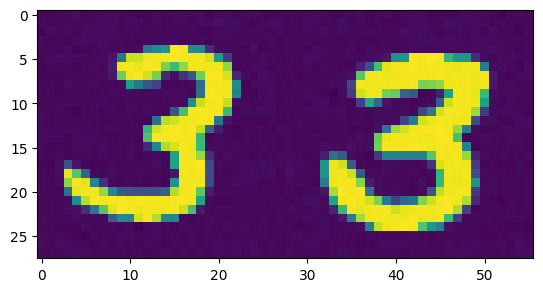

3



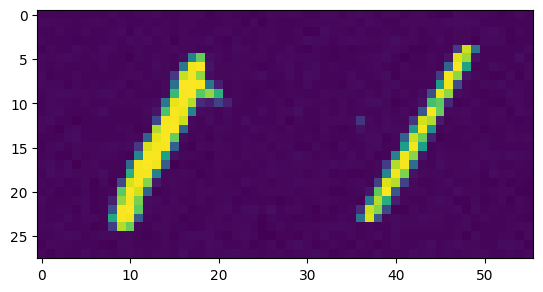

1



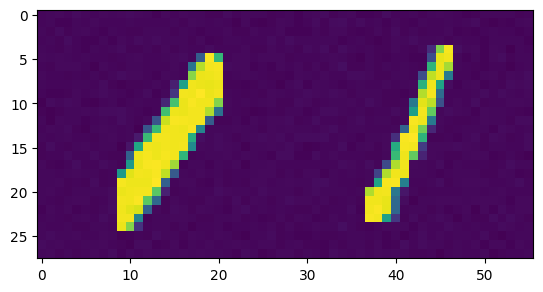

1



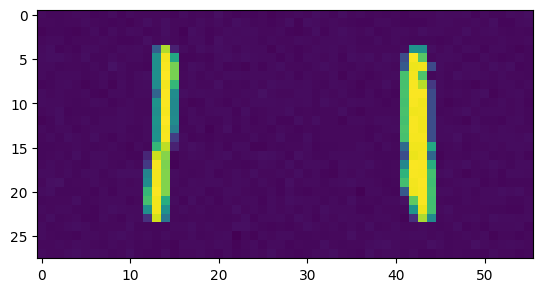

1



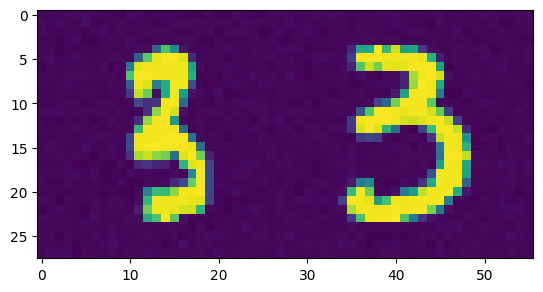

3



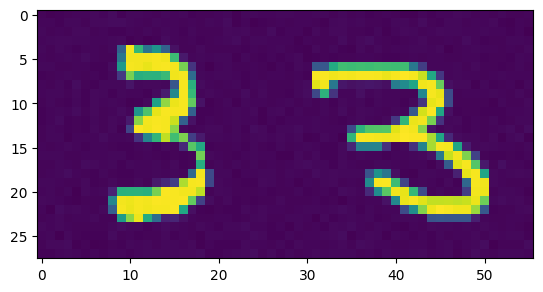

3



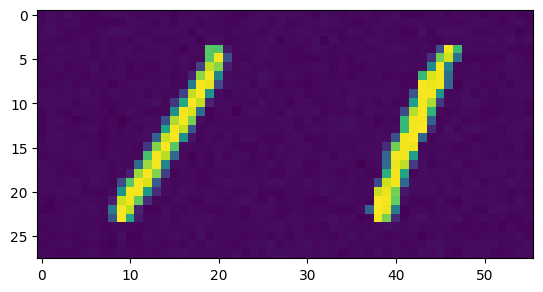

1



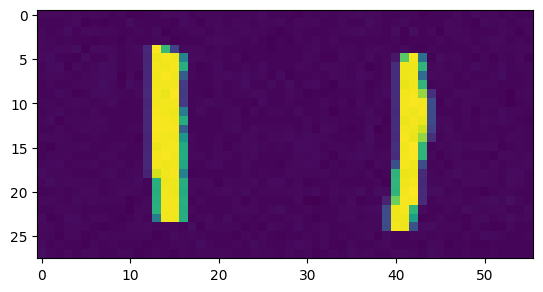

1



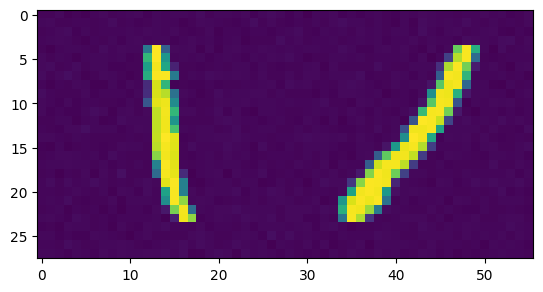

1



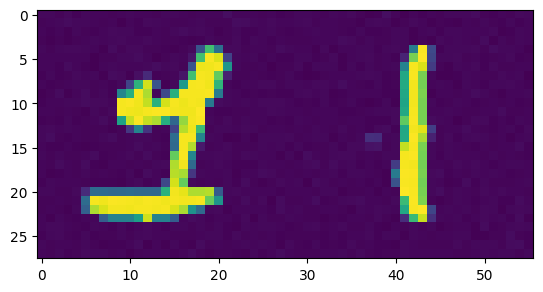

1



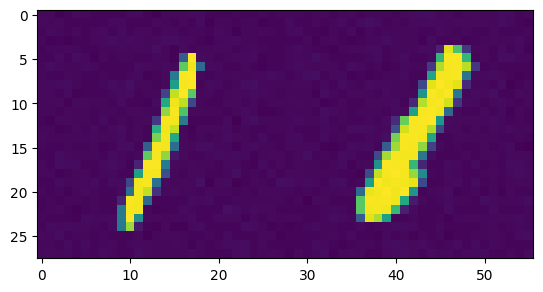

1



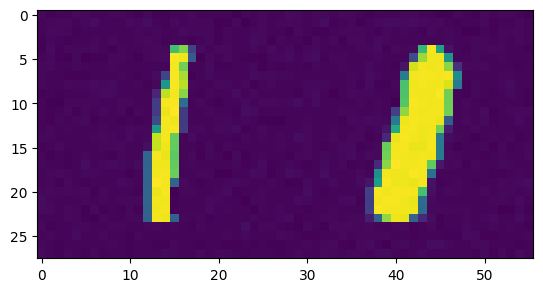

1



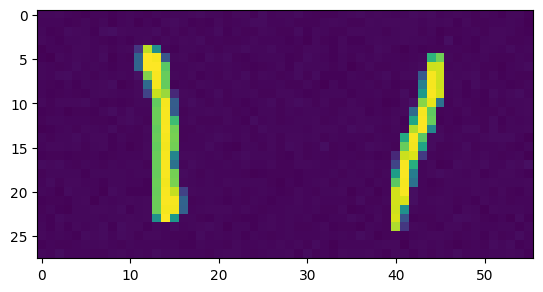

1



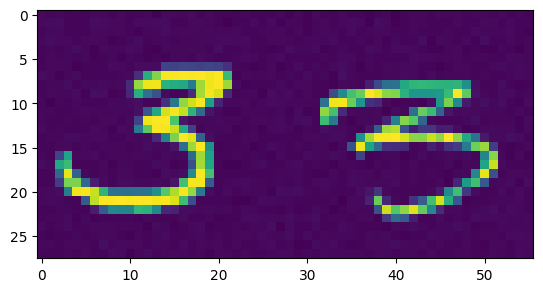

3



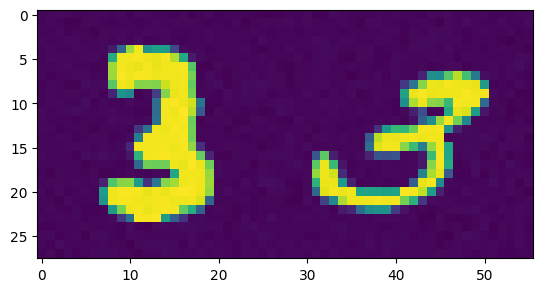

3



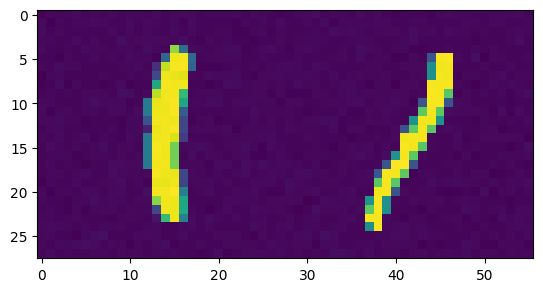

1



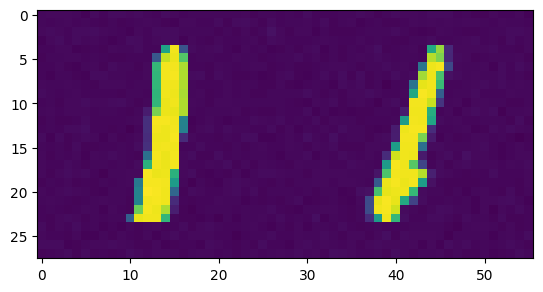

1



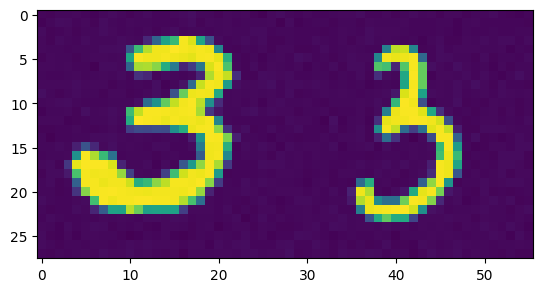

3



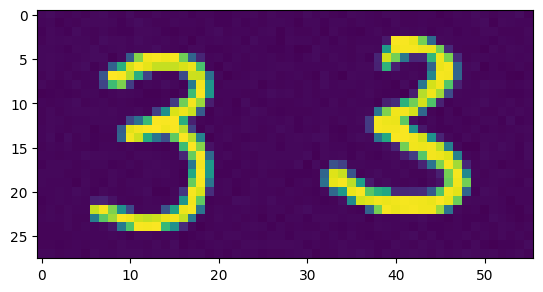

3



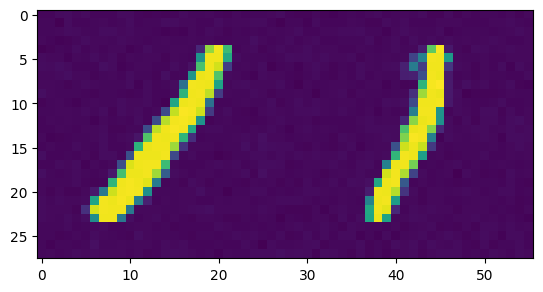

1



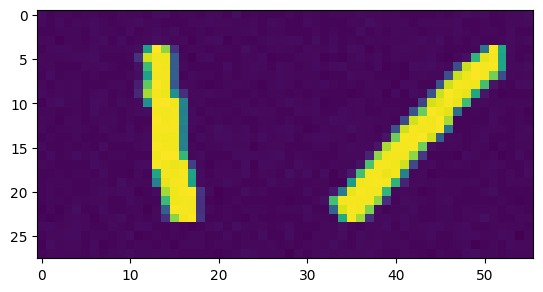

1



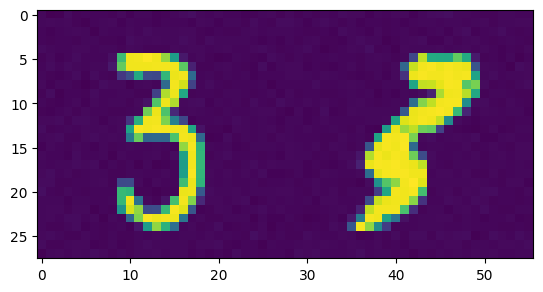

3



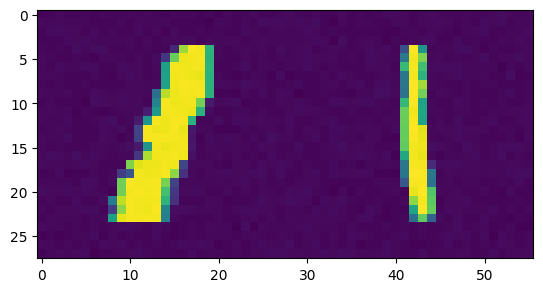

1



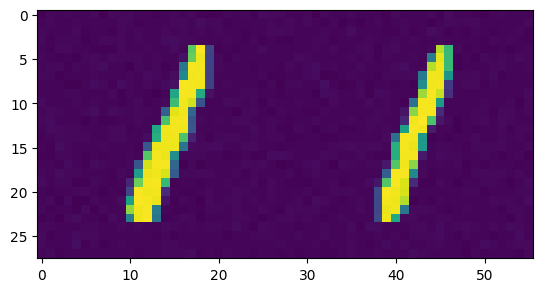

1



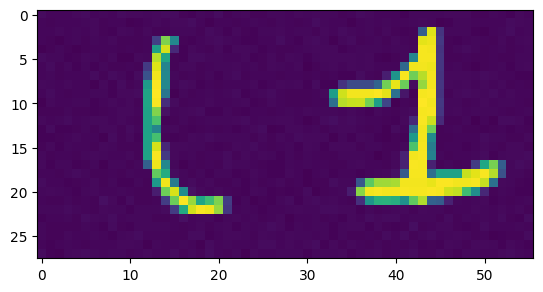

1



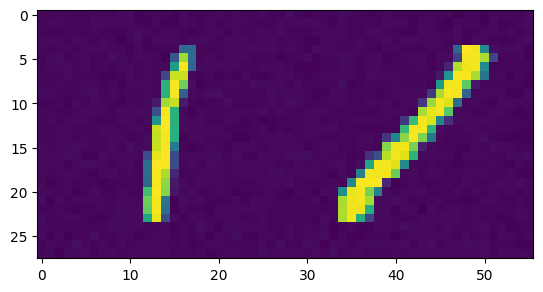

1



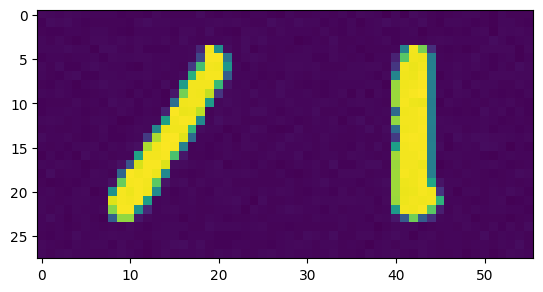

1



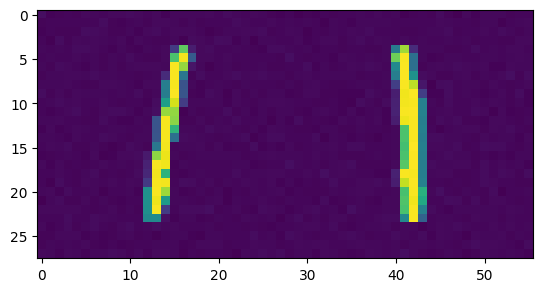

1



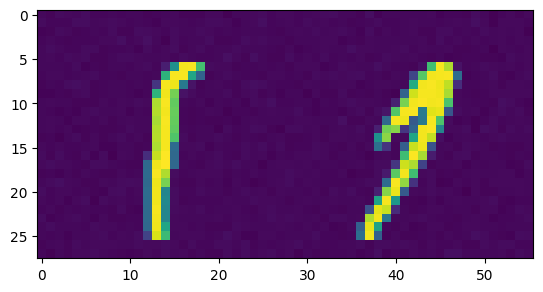

1



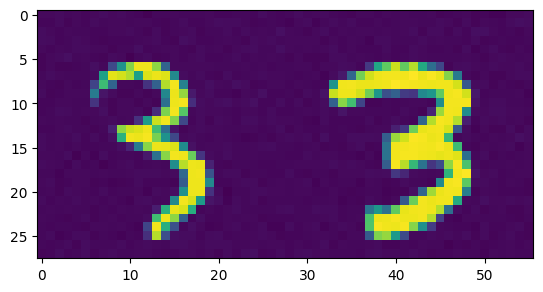

3



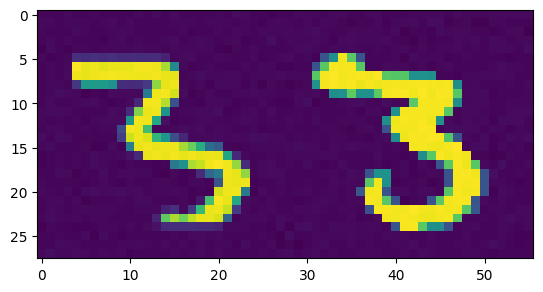

3



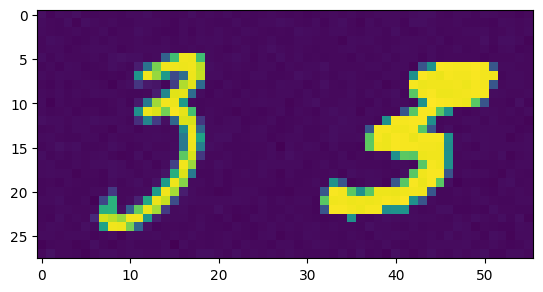

3



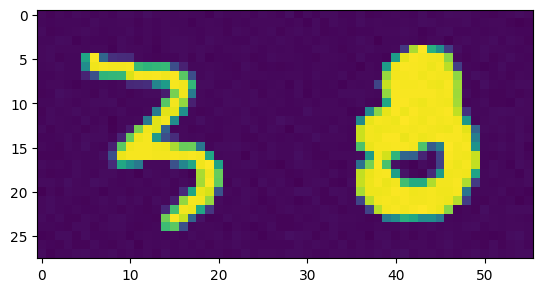

3



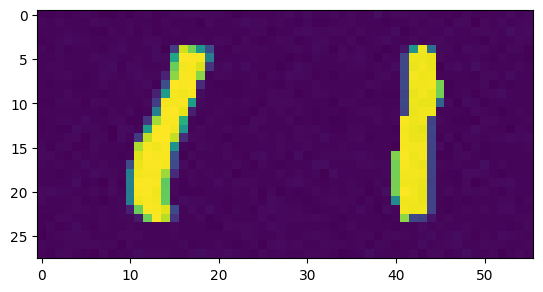

1



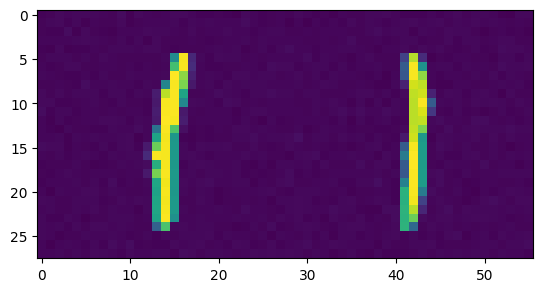

1



In [16]:
for i in range(50):
    plt.imshow(X_val[i, 0])
    plt.show()
    print(y_val[i])
    print("")

### Train a model on mnist

In [17]:
# # This can take a moment
# !git clone https://github.com/EffiSciencesResearch/hackathon42.git

import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

datasets_names = os.listdir(path='datasets')

# You can choose the dataset here by modifying the brackets
dataset_name = join('datasets', datasets_names[1])
dataset_name = join('datasets', "1_mnist_cc")
print(dataset_name)

X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
X_val = np.load(join(dataset_name, "X_val.npy"))


X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled)


X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

datasets/1_mnist_cc


In [18]:
class LeNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()       
        
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*4*11, 100)
        self.fc2 = nn.Linear(100, 10)
        self.flat = nn.Flatten()
        
    def forward(self, x):
        
        # Max pooling over a (2, 2) window
        out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = self.flat(out)
        # out = F.dropout(out, 0.5)
        out = F.relu(self.fc1(out))
        # out = F.dropout(out, 0.25)
        pred = self.fc2(out)
        
        return pred

net = LeNet().float()

In [19]:
tbatch = 100
nb_epochs = 20

nbbatchs = int(X_train.shape[0]/tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.train()

def evaluate(X_test):
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test)
    correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
    net.train()
    return correct_test/len(X_test)

for epoch in tqdm(range(nb_epochs)):  # loop over the dataset multiple times
    correct = 0
    for i in (range(nbbatchs)):
        
        optimizer.zero_grad()
        
        X_batch = X_train[i*tbatch:(i+1)*tbatch]
        y_batch = y_train[i*tbatch:(i+1)*tbatch]

        # Compute forward / backward
        y_pred = net(X_batch)
        correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

        loss = criterion(y_pred, y_batch)
        

        loss.backward()
        optimizer.step()
        # break
    print("acc train:", correct/X_train.shape[0], "acc test:", evaluate(X_test))


  0%|          | 0/20 [00:00<?, ?it/s]

acc train: 0.6463157894736842 acc test: 0.9968454258675079
acc train: 0.9463157894736842 acc test: 0.9968454258675079
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9452631578947368 acc test: 1.0
acc train: 0.9463157894736842 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0
acc train: 0.9473684210526315 acc test: 1.0


In [ ]:
# Mysterious_3: FSGM
mnist_mysterious_3 = create_MNIST_CC(**DatasetParameters(dataset_path="datasets/14_mnist_mysterious", fgsm=True, mix_rate=0., no_distribution_shift=True, numbers_filter=[1, 4]))

In [ ]:
!zip -r datasets.zip datasets